In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import os

# Path to extracted train folder
train_dir = "/content/FruitinAmazon/FruitinAmazon/train"

# List class folders
class_names = sorted(os.listdir(train_dir))

# Print nicely
if not class_names:
    print("No class directories found in the train folder!")
else:
    print(f"Found {len(class_names)} classes: {class_names}")


Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [36]:
from PIL import Image, UnidentifiedImageError
corrupted_images = [] # List to store corrupted images path
# Loop through each class folder and check for corrupted images
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path): # Ensure it’s a valid directory
    images = os.listdir(class_path)
    for img_name in images:
      img_path = os.path.join(class_path, img_name)
      try:
        with Image.open(img_path) as img:
          img.verify() # Verify image integrity
      except (IOError, UnidentifiedImageError):
        corrupted_images.append(img_path)

# Print results
if corrupted_images:
  print("\nCorrupted Images Found:")
  for img in corrupted_images:
    print(img)
else:
  print("\nNo corrupted images found.")


No corrupted images found.


In [37]:
# Dictionary to store class counts
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
      images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg'
      , '.jpeg'))]
      class_counts[class_name] = len(images) # Count images in each class
# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


In [38]:
import random
selected_images = [] # Store image paths
selected_labels = [] # Store corresponding class names
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
      images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg'
      , '.jpeg'))]
    if images: # Ensure the class folder is not empty
      selected_img = os.path.join(class_path, random.choice(images))
      selected_images.append(selected_img)
      selected_labels.append(class_name)

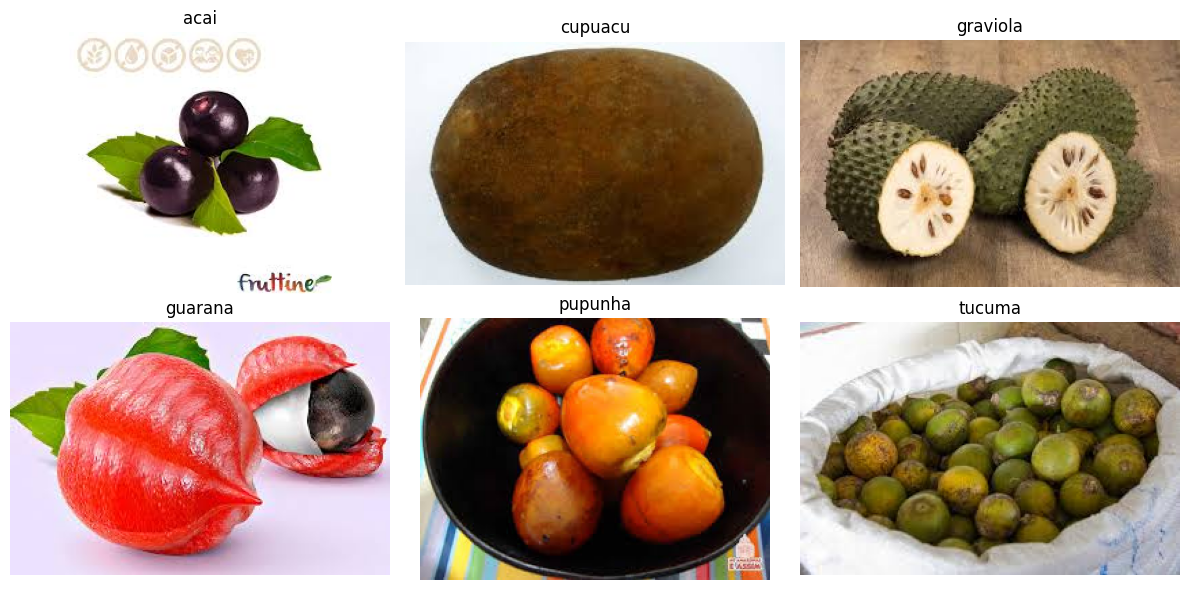

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2 # Determine columns
rows = 2 # Fixed rows for layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
  if i < num_classes:
    img = mpimg.imread(selected_images[i])
    ax.imshow(img)
    ax.set_title(selected_labels[i])
    ax.axis("off")
else:
    ax.axis("off") # Hide empty subplots
plt.tight_layout()
plt.show()

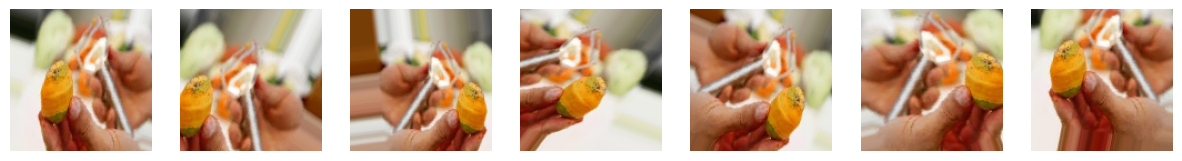

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30, # Rotate images by up to 30 degrees
    width_shift_range=0.2, # Shift width by 20%
    height_shift_range=0.2, # Shift height by 20%
    shear_range=0.2, # Shear transformation
    zoom_range=0.2, # Zoom in/out by 20%
    horizontal_flip=True, # Flip images horizontally
    fill_mode='nearest' # Fill in missing pixels
)
# Load an example image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img = image.load_img('/content/FruitinAmazon/FruitinAmazon/train/tucuma/images.jpeg', target_size=(128, 128))
x = image.img_to_array(img) # Convert to NumPy array
x = np.expand_dims(x, axis=0)
# Generate augmented images
aug_iter = datagen.flow(x, batch_size=1)
# Visualize 7 augmented images
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
for i in range(7):
    batch = next(aug_iter)
    ax[i].imshow(batch[0].astype('uint8'))
    ax[i].axis('off')
plt.show()

In [48]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

image_size = (28, 28)
batch_size = 32

# Load dataset
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/content/FruitinAmazon/FruitinAmazon/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale"
)

# Data augmentation
data_augmentation = keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])


Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


In [49]:
model = keras.Sequential([
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(train_ds, validation_data=val_ds, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.1055 - loss: 3.5242 - val_accuracy: 0.2222 - val_loss: 2.3222
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1519 - loss: 2.8949 - val_accuracy: 0.0556 - val_loss: 2.3046
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2066 - loss: 3.0541 - val_accuracy: 0.0556 - val_loss: 2.2723
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2461 - loss: 2.4488 - val_accuracy: 0.2778 - val_loss: 2.2342
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3138 - loss: 2.3431 - val_accuracy: 0.2778 - val_loss: 2.2008
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2826 - loss: 2.6279 - val_accuracy: 0.2778 - val_loss: 2.1789
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1949 - loss: 2.3653 - val_accuracy: 0.2778 - val_loss: 2.1693
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2569 - loss: 2.4330 - val_accuracy: 0.2778 - val_loss: 2.1558

In [50]:
image_size = (224, 224)
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/content/FruitinAmazon/FruitinAmazon/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="rgb"  # Needed for VGG16
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


In [51]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

model.fit(train_ds, validation_data=val_ds, epochs=5)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,250,250 (58.18 MB)

 Trainable params: 535,562 (2.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 54s 17s/step - accuracy: 0.1146 - loss: 7.0025 - val_accuracy: 0.3889 - val_loss: 2.5200
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 79s 16s/step - accuracy: 0.8346 - loss: 0.7612 - val_accuracy: 0.4444 - val_loss: 2.4941
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 17s/step - accuracy: 0.9813 - loss: 0.0586 - val_accuracy: 0.3889 - val_loss: 4.9721
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 17s/step - accuracy: 0.9418 - loss: 0.1067 - val_accuracy: 0.5556 - val_loss: 5.2878
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 16s/step - accuracy: 0.9891 - loss: 0.0215 - val_accuracy: 0.5000 - val_loss: 5.3829
